# LSTM

In [2]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

/Users/alexherron/opt/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Read in model, clean data
medium_data = pd.read_csv('medium_data.csv')
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

In [4]:
# Shuffle rows, set train and test data
frac_test = 0.15
num_test_rows = int(len(medium_data) * frac_test)
num_train_rows = len(medium_data) - num_test_rows
medium_data = medium_data.sample(frac=1)
test_data = medium_data.tail(num_test_rows)
test_data.to_csv('test_data.csv')
medium_data = medium_data.head(num_train_rows)
medium_data.to_csv('train_data.csv')

In [5]:
# Set tokenizer for words not in vocab
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

# Create list of sequences
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        
# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Convert labels to binary predictions
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Print number of sequences
num_sequences = len(input_sequences)
print("Total input sequences: ", num_sequences)

Total input sequences:  41193


In [6]:
# Set model
model = Sequential()
model.add(Embedding(total_words,
                    100,
                    input_length=max_sequence_len-1))
model.add(layers.LSTM(150))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()])

# Train model
history = model.fit(xs, ys, epochs=50, verbose=1)
print(model)

/Users/alexherron/opt/miniconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
1288/1288 [==============================] - 43s 32ms/step - loss: 6.8046 - accuracy: 0.1181 - precision: 0.8501 - recall: 0.0560
Epoch 2/50
1288/1288 [==============================] - 39s 30ms/step - loss: 5.8343 - accuracy: 0.1715 - precision: 0.8009 - recall: 0.0855
Epoch 3/50
1288/1288 [==============================] - 52s 40ms/step - loss: 4.9632 - accuracy: 0.2019 - precision: 0.7536 - recall: 0.1046
Epoch 4/50
1288/1288 [==============================] - 50s 39ms/step - loss: 4.1362 - accuracy: 0.2521 - precision: 0.7179 - recall: 0.1339
Epoch 5/50
1288/1288 [==============================] - 46s 36ms/step - loss: 3.4849 - accuracy: 0.3116 - precision: 0.7294 - recall: 0.1838
Epoch 6/50
1288/1288 [==============================] - 46s 36ms/step - loss: 3.0686 - accuracy: 0.3614 - precision: 0.7467 - recall: 0.2293
Epoch 7/50
1288/1288 [==============================] - 43s 33ms/step - loss: 2.7693 - accuracy: 0.4028 - precision: 0.7559 - recall: 0.2714
Epoch 8/50
12

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.grid()
    plt.show()

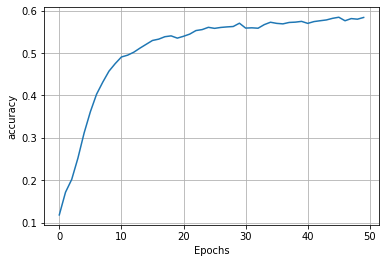

In [14]:
plot_graphs(history, 'accuracy')

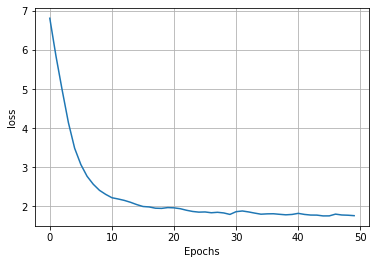

In [15]:
plot_graphs(history, 'loss')

In [31]:
for key, value in history.history.items():
    print(key)

loss
accuracy
precision
recall


In [32]:
accuracy = history.history['accuracy']
loss = history.history['loss']
precision = history.history['precision']
recall = history.history['recall']

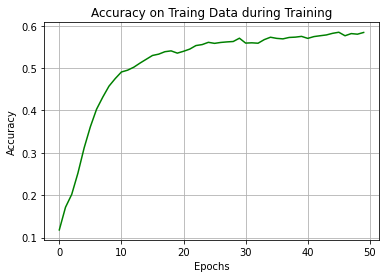

In [26]:
plt.plot(accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy on Traing Data during Training')
plt.grid()
plt.show()

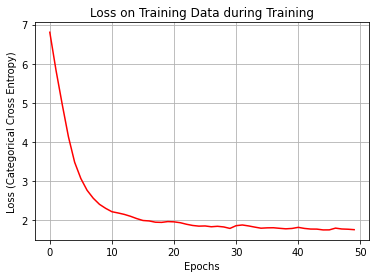

In [27]:
plt.plot(loss, color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss (Categorical Cross Entropy)')
plt.title('Loss on Training Data during Training')
plt.grid()
plt.show()

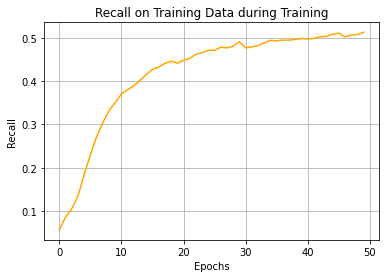

In [35]:
plt.plot(recall, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall on Training Data during Training')
plt.grid()
plt.show()

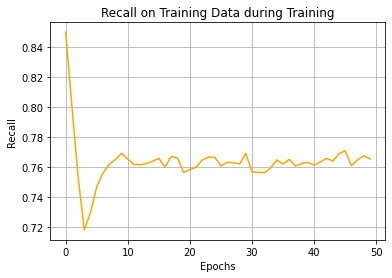

In [36]:
plt.plot(precision, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall on Training Data during Training')
plt.grid()
plt.show()

In [10]:
# Save model

model.save('lstm_2')

2023-05-08 13:44:07.503258: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: lstm_2/assets


INFO:tensorflow:Assets written to: lstm_2/assets


In [38]:
publications = medium_data['publication']
publications.value_counts()

The Startup                2569
Towards Data Science       1245
Data Driven Investor        676
UX Collective               473
The Writing Cooperative     330
Better Marketing            213
Better Humans                26
Name: publication, dtype: int64

In [51]:
dates = sorted(medium_data['date'])

first_date = dates[0]
last_date = dates[-1]

print(f'First date: {first_date}')
print(f'Lirst date: {last_date}')

First date: 2019-01-26
Lirst date: 2019-12-30


(array([2673., 1179.,  559.,  319.,  177.,  118.,   81.,   66.,   43.,
          40.,   60.,   19.,   18.,   20.,   11.,   14.,    9.,    4.,
          12.,   10.]),
 array([   0.,  110.,  220.,  330.,  440.,  550.,  660.,  770.,  880.,
         990., 1100., 1210., 1320., 1430., 1540., 1650., 1760., 1870.,
        1980., 2090., 2200.]),
 <BarContainer object of 20 artists>)

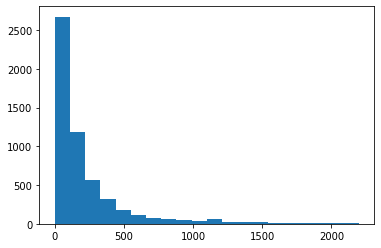

In [62]:
claps = sorted(medium_data['claps'])
#print(len(claps))
claps = claps[:-100]
plt.hist(claps, bins=20)

In [68]:
titles = medium_data['title']

title_lengths = []
for i in titles:
    title_lengths.append(len(i.split()))

Text(0.5, 1.0, 'Histogram of Title Length (Number of Words)')

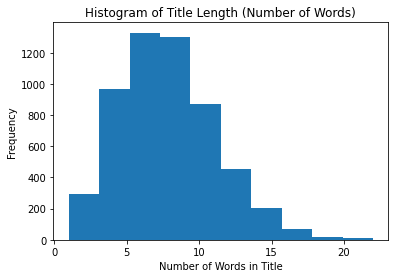

In [74]:
plt.hist(title_lengths, bins=10)
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.title('Histogram of Title Length (Number of Words)')

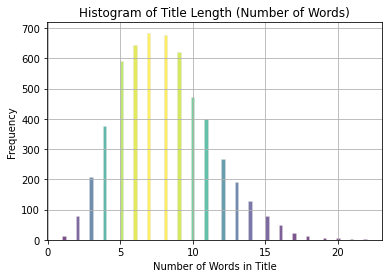

In [80]:
n, bins, patches = plt.hist(title_lengths, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.title('Histogram of Title Length (Number of Words)')
plt.grid()
plt.show()

In [96]:
from collections import Counter

all_text = ''
for i in titles:
    all_text += i.lower() + ' '
all_text = all_text.split()

In [97]:
counter = Counter(all_text)
counter.most_common(20)

[('the', 1565),
 ('to', 1558),
 ('a', 1105),
 ('of', 818),
 ('how', 762),
 ('and', 760),
 ('your', 701),
 ('in', 682),
 ('for', 599),
 ('you', 519),
 ('with', 439),
 ('is', 417),
 ('—', 379),
 ('data', 322),
 ('<strong', 291),
 ('class="markup--strong', 291),
 ('why', 288),
 ('on', 258),
 ('what', 247),
 ('i', 246)]

In [98]:
bigrams = zip(all_text, all_text[1:])
counts = Counter(bigrams)
counts.most_common()

[(('how', 'to'), 463),
 (('<strong', 'class="markup--strong'), 291),
 (('machine', 'learning'), 115),
 (('of', 'the'), 91),
 (('in', 'the'), 80),
 (('data', 'science'), 78),
 (('to', 'be'), 72),
 (('as', 'a'), 63),
 (('—', 'a'), 61),
 (('ways', 'to'), 60),
 (('guide', 'to'), 58),
 (('need', 'to'), 56),
 (('to', 'make'), 55),
 (('a', 'ux'), 52),
 (('deep', 'learning'), 51),
 (('you', 'need'), 51),
 (('how', 'i'), 48),
 (('to', 'get'), 45),
 (('why', 'you'), 44),
 (('to', 'write'), 42),
 (('artificial', 'intelligence'), 42),
 (('in', 'python'), 41),
 (('what', 'is'), 41),
 (('in', 'a'), 40),
 (('to', 'the'), 39),
 (('is', 'the'), 39),
 (('you', 'should'), 39),
 (('for', 'the'), 38),
 (('case', 'study'), 38),
 (('is', 'a'), 38),
 (('i', 'learned'), 37),
 (('neural', 'networks'), 37),
 (('the', 'best'), 37),
 (('introduction', 'to'), 37),
 (('want', 'to'), 36),
 (('and', 'the'), 36),
 (('the', 'future'), 36),
 (('on', 'the'), 36),
 (('to', 'create'), 34),
 (('for', 'your'), 34),
 (('and', 